# Assignment 3: Neural Neyworks

## In this assignment, you will use a neural network to recognize the hand-written digits 0-9.

## 1. Import statements

The packages need for this assignment are **numpy**, **matplotlib**, and **tensorflow**. You also need to import the following modules from **keras**:
- **Sequential** (from **models**)
- **Dense** (from **layers**)
- **linear**, **relu**, **sigmoid** (from **activations**)

In [56]:
# import statements
# *** YOUR CODE HERE ***
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.api.layers import InputLayer, Dense
from keras.api.models import Sequential
from keras.api.activations import sigmoid, relu, linear
from keras.api.losses import SparseCategoricalCrossentropy
from keras.api.optimizers import Adam


## 2. The Softmax Function
#### The softmax function converts a vector $\mathbf{z}=[z_0,...z_{n-1}]$ of real numbers into a probability distribution:
$$ \sigma(\mathbf{z}) = \left[\frac{e^{z_0}}{ \sum_{i=0}^{n-1}{e^{z_i} }} ... \frac{e^{z_{n-1}}}{ \sum_{i=0}^{n-1}{e^{z_i} }}\right] $$
#### When used for multiclass classification, $z = \mathbf{w} \cdot \mathbf{x} + b$ is the **logits** vector, and $n$ is the number of neurons in the output layer.<br>
#### Implement the sigmoid function in numpy.


In [57]:
def my_softmax(z):
    """
    Compute the softmax function
    Args:
        z (ndarray (n,)): the input vector, ndarray of length n
    Returns:
        a (ndarray (n,)): softmax of z, with the same shape as z
    """
    # *** YOUR CODE HERE ***
    z = z -np.max(z)
    exp = np.exp(z)
    a = exp / np.sum(exp)
    return a

#### Compare your softmax implementation to tensorflow softmax, using the test below:

In [58]:
def test_my_softmax(z):
    a = my_softmax(z)
    atf = tf.nn.softmax(z)
    print(f"z:                     {z}")
    print(f"my_softmax(z):         {a}")
    print(f"tensorflow softmax(z): {atf}")
    assert np.allclose(a, atf, atol=1e-10), f"Wrong values. Expected {atf}, got {a}"
    print("Test passed")

z = np.array([1., 2., 3., 4.])
test_my_softmax(z)
z = np.array([np.log(0.1)] * 10)
test_my_softmax(z)

z:                     [1. 2. 3. 4.]
my_softmax(z):         [0.0320586  0.08714432 0.23688282 0.64391426]
tensorflow softmax(z): [0.0320586  0.08714432 0.23688282 0.64391426]
Test passed
z:                     [-2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509
 -2.30258509 -2.30258509 -2.30258509 -2.30258509]
my_softmax(z):         [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
tensorflow softmax(z): [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test passed


#### Complete the function below to plot z and my_softmax(z) side by side. Hint: use plt.subplot and the bar plot.

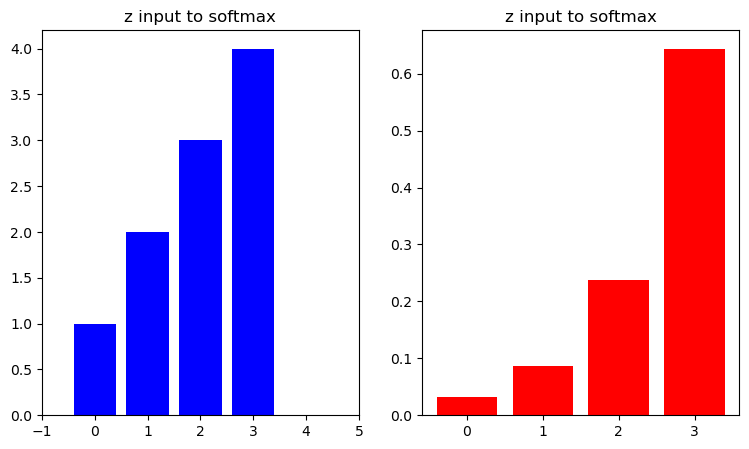

In [59]:
def plt_softmax(z):
    """
    Plot z and my_softmax(z) side by side
    Args:
        z (ndarray (n,)): the input vector, ndarray of length n
    Returns:
        None
    """
    # *** YOUR CODE HERE ***
    a = my_softmax(z)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 5) )
    axs[0].bar(range(len(z)), z, color='b')
    axs[0].set_title('z input to softmax')
    axs[0].set_xlim(-1,5)
    
    axs[1].bar(range(len(a)), a, color='r')
    axs[1].set_title('z input to softmax')
    plt.show()
    
plt.close("all")
plt_softmax(np.array([1., 2., 3., 4.]))

## 3. Handwritten Digit Recognition
#### In handwritten digit recognition problem, you receive a handwritten image of a digit, and classify it into one of 10 classes. We start with the dataset.

### 3.1. The MNIST Dataset
The MNIST dataset (Modified National Institute of Standards and Technology) is a widely used benchmark dataset in machine learning, particularly for image classification tasks. It consists of 70,000 labeled grayscale images of handwritten digits, ranging from 0 to 9, each of size 28x28 pixels. Each pixel is a number that indicates the pixel's grayscale intensity, ranging from 0 (black - no intensity) to 255 (white - maximum intensity).
#### Loading MNIST
TensorFlow provides a built-in function to load MNIST.

In [60]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [61]:
# Print the type and shape of x_train, y_train, x_test, y_test. Print also the min, max, and average values, to get an idea of the data.
# *** YOUR CODE HERE ***
print(f"x_train: type = {type(x_train)}, shape = {x_train.shape}, min = {x_train.min()}, max = {x_train.max()}, mean = {x_train.mean():.2f}") 
print(f"y_train: type = {type(y_train)}, shape = {y_train.shape}, min = {y_train.min()}, max = {y_train.max()}, mean = {y_train.mean():.2f}") 
print(f"x_test: type = {type(x_test)}, shape = {x_test.shape}, min = {x_test.min()}, max = {x_test.max()}, mean = {x_test.mean():.2f}") 
print(f"y_test: type = {type(y_test)}, shape = {y_test.shape}, min = {y_test.min()}, max = {y_test.max()}, mean = {y_test.mean():.2f}") 

x_train: type = <class 'numpy.ndarray'>, shape = (60000, 28, 28), min = 0, max = 255, mean = 33.32
y_train: type = <class 'numpy.ndarray'>, shape = (60000,), min = 0, max = 9, mean = 4.45
x_test: type = <class 'numpy.ndarray'>, shape = (10000, 28, 28), min = 0, max = 255, mean = 33.79
y_test: type = <class 'numpy.ndarray'>, shape = (10000,), min = 0, max = 9, mean = 4.44


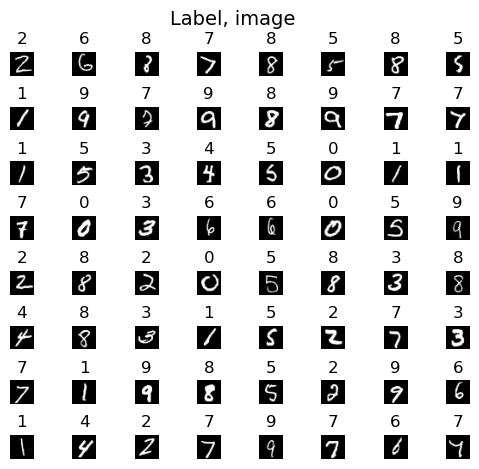

In [62]:
# Visualize the data. You do not need to modify anything in this cell
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.close("all")
fig, axes = plt.subplots(8,8, figsize=(5,5))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]
m = x_train.shape[0]

for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)

    # Display the image
    ax.imshow(x_train[random_index], cmap='gray')

    # Display the label above the image
    ax.set_title(y_train[random_index])
    ax.set_axis_off()
    fig.suptitle("Label, image", fontsize=14)
plt.show()

#### Normalization
Using the raw values is not recommended - they are large, and gradient descent can be slow. You should normalize all x values to be between 0 and 1.

In [63]:
# Normalize x values. Print min, max and mean.

# *** YOUR CODE HERE ***
x_train_norm = x_train / 255
x_test_norm = x_test / 255

print(f"= x_train_norm: min = {x_train_norm.min()}, max = {x_train_norm.max()}, mean = {x_train_norm.mean():.2f}")
print(f"= x_test_norm: min = {x_test_norm.min()}, max = {x_test_norm.max()}, mean = {x_test_norm.mean():.2f}")

= x_train_norm: min = 0.0, max = 1.0, mean = 0.13
= x_test_norm: min = 0.0, max = 1.0, mean = 0.13


The training and test set are currently 3d arrays:
- the first dimension (shape[0]) is the number of training/test instances;
- the second and third dimension (shape[1], shape[2]) hold the image in a 28x28 grid.

To use it as an input, you need to convert each set into a 2d array:
- shape[0] is the number of instances
- shape[1] is the number of features (in this case, 28*28 = 784)

In [64]:
# Convert the x sets into 2-d arrays

# *** YOUR CODE HERE ***
x_train_reshaped = x_train_norm.reshape(x_train_norm.shape[0], -1)
x_test_reshaped = x_test_norm.reshape(x_test_norm.shape[0], -1)

print(f"x_train_reshaped shape = {x_train_reshaped.shape}")
print(f"x_test_reshaped shape = {x_test_reshaped.shape}")


x_train_reshaped shape = (60000, 784)
x_test_reshaped shape = (10000, 784)


### 3.2. Training


The neural network you will use in this assignment is shown in the figure below. It has two dense layers with ReLU activations followed by an output layer with a linear activation. The softmax is applied by the cost function, like we saw in the lecture.

<img src="ass3_NN.png" width="600" height="450">

In [65]:
# Create the model in tensorflow
tf.random.set_seed(42) # for consistent results
# *** YOUR CODE HERE ***
model = Sequential(
    [InputLayer((784,)),
    Dense(25, activation='relu', name='L1'),
    Dense(15, activation='relu', name='L2'),
    Dense(10, activation='linear', name='L3')
])

In [66]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ L1 (Dense)                      │ (None, 25)             │        19,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2 (Dense)                      │ (None, 15)             │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L3 (Dense)                      │ (None, 10)             │           160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,175 (78.81 KB)

 Trainable params: 20,175 (78.81 KB)

 Non-trainable params: 0 (0.00 B)

The parameter counts shown in the summary correspond to the number of elements in the weight and bias arrays as shown below.

Let's further examine the weights to verify that tensorflow produced the same dimensions as we calculated above.

In [67]:
[layer1, layer2, layer3] = model.layers

In [68]:
#### Examine Weights shapes
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (784, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 10), b3 shape = (10,)


Compile the model:
* specify a loss function, `SparseCategoricalCrossentropy`. Make sure you apply it to the logits!
* specify an optimizer. A popular choice is Adaptive Moment (Adam) which was described in lecture.

In [69]:
# *** YOUR CODE HERE ***
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer=Adam(learning_rate=1e-3), metrics=[]) #use what we seen in the lcture


Train the model.

In [70]:
history = model.fit(x_train_reshaped, y_train, epochs=100) # 100 epochs like lecture

Epoch 1/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.7405
Epoch 2/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2233
Epoch 3/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1772
Epoch 4/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1508
Epoch 5/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1332
Epoch 6/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1198
Epoch 7/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1096
Epoch 8/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1012
Epoch 9/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0942
Epoch 10/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0881
Epoch 11/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0827
Epoch 12/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0776
Epoch 13/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0737
Epoch 14/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0702
Epoch 15/100
18

#### Epochs and batches
In the `compile` statement above, the number of `epochs` was set to 100. This specifies that the entire data set should be applied during training 100 times.  During training, you see output describing the progress of training that looks like this:
```
Epoch 1/100
1875/1875 [==============================] - 0s 1ms/step - loss: 2.2770
```
The first line, `Epoch 1/100`, describes which epoch the model is currently running. For efficiency, the training data set is broken into 'batches'. The default size of a batch in Tensorflow is 32. There are 60000 examples in our data set or 1875 batches. The notation on the 2nd line `1875/1875 [====` is describing which batch has been executed.

#### Loss  (cost)
When we train a model, the cost should decrease as the number of iterations of the algorithm increases. Tensorflow refers to the cost as `loss`. Above, you saw the loss displayed each epoch as `model.fit` was executing. The [.fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model) method returns a variety of metrics, including the loss, encapsulated in the `history` variable. We can use this variable to plot the learning curve, and make sure the loss indeed decreases.

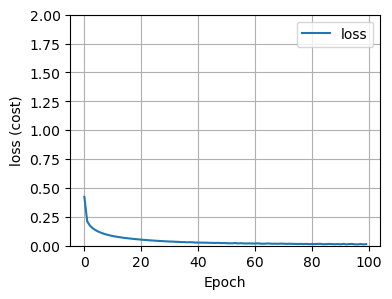

In [71]:
def plot_loss_tf(history):
    fig,ax = plt.subplots(1,1, figsize = (4,3))
    ax.plot(history.history['loss'], label='loss')
    ax.set_ylim([0, 2])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('loss (cost)')
    ax.legend()
    ax.grid(True)
    plt.show()

plot_loss_tf(history)


### 3.3. Evaluation

#### Prediction
Let's test the trained model on the first test sample.

First test sample:


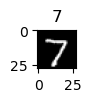

In [72]:
# The code below displays a digit in an 28x28 format
def display_digit(d):
    fig, ax = plt.subplots(1,1, figsize=(0.5,0.5))
    ax.imshow(d, cmap='gray')
    ax.set_title(y_test[0])
    plt.show()

print("First test sample:")
display_digit(x_test[0])

To make a prediction, we use  `model.predict(input)`. <br>
Apply the model to the first sample in the test set and print the resulting output. <br>
**Note** The shape of your input should be (1, 784)

In [77]:
# *** YOUR CODE HERE ***
prediction = model.predict(x_test_norm[0].reshape(1, 784))
print(f"Model output on first test sample: \n{prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Model output on first test sample: 
[[-38.019634  -14.494167    0.8436324   1.5238676 -30.117853  -14.705193
  -65.461975   36.88554    -3.7543225  -3.747152 ]]


Since we trained the model with a linear activation in the final layer, the output is a vector of real numbers.<br>
 If the problem requires a probability distribution, we should apply `softmax`. <br>
In the multiclass classification case, it is enough to use `argmax`.

In [78]:
# Predict a class based on the model output.

# *** YOUR CODE HERE ***
number = np.argmax(prediction)

print(f"Prediction: {number}")

Prediction: 7


#### Model Evaluation
Compute the model predictions on the test set, and print shape, min, max and mean of your predictions vector. <br>
Your prediction vector should have the same shape as y_test.


In [79]:
# *** YOUR CODE HERE ***
test_predictions = model.predict(x_test_reshaped)
predicted_classes = np.argmax(test_predictions, axis=1)

# Print the required statistics
print(f"test_predictions: shape = {predicted_classes.shape}, "
      f"min = {predicted_classes.min()}, "
      f"max = {predicted_classes.max()}, "
      f"mean = {predicted_classes.mean():.2f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
test_predictions: shape = (10000,), min = 0, max = 9, mean = 4.44


Use the following modules from sklearn.metrics to evaluate you model:
- accuracy_score
- confusion_matrix
- classification_report

You can find the documentation [here](https://scikit-learn.org/stable/api/sklearn.metrics.html).


In [80]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# *** YOUR CODE HERE ***
accuracy = accuracy_score(y_test, predicted_classes)
print(f"Accuracy: {accuracy:.2f}\n")

conf_matrix = confusion_matrix(y_test, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test, predicted_classes)
print("\nClassification Report:")
print(class_report)

Accuracy: 0.96

Confusion Matrix:
[[ 957    0    3    2    2    4    7    3    2    0]
 [   1 1105    6    1    2    0    4    2   14    0]
 [   4    1  991    4    3    3    5    9   12    0]
 [   1    0    7  968    0    9    2    6    8    9]
 [   1    1    9    0  933    0   12    6    5   15]
 [   8    0    1   11    3  840   16    1    6    6]
 [   7    1    3    1    9    9  927    0    1    0]
 [   2    5   13   10    4    0    1  979    6    8]
 [   5    1    3   12    3   11    8    9  918    4]
 [   2    4    0    9   14    8    3   20   10  939]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       980
           1       0.99      0.97      0.98      1135
           2       0.96      0.96      0.96      1032
           3       0.95      0.96      0.95      1010
           4       0.96      0.95      0.95       982
           5       0.95      0.94      0.95       892
           6       0.94      0.9

Examine the confusion matrix. What digits does the model tend to confuse? Explain your answer.

*** YOUR ANSWER HERE ***

I've ran the train model a couple of times, each time observing varying but close results.

But the most consistent thing I could observe was that for example the 1's and the 0's 

Had a pretty high precision rate across all tries, due to the lack of overlap with the other digits in the way they're written.
Which meant higher precision rate as they're not confused with the resst of the digits
However, the model did tend to confuse a few digits, this last run of mine for example,

I could observe that the model confused the digits 7 and 9, possibly due to the 7's being written in a way that resembles a 9.
Which might've made it difficult to predict correctly.

And generally speaking from what I've observed.
The 3's tend to be confused with the 5's, Since both have rounds and can look similar depending on the writing style
The 3's also were confused with the 8's, again both having similar round styles when written. 

And a confusion that almost always showed up was the confusion between the 4's and the 9's,
A poorly written 4 can easily appear as a 9, and vice versa, a mistake even we humans tend to make. So it's something that caught my eye as well when I analyzed the confusion matrices
and wasn't surprised to see.

The 2's also had their fair share of the confusion, I mostly observed 2's being mistaken for 7's, and 8's
In general, the confusion happens due to some numbers in certain handwriting styles looking similar to othen digits

We could need better and diverse samples or have a larger data to train the model with, to increase precision.
Because it is clear the model struggled and was limited when it comes to certain digits.







